In [25]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

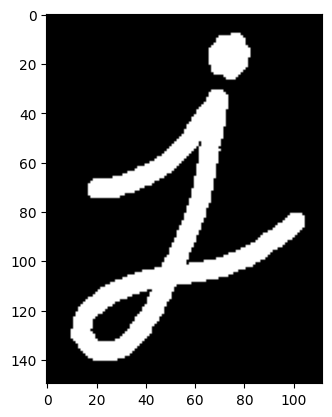

In [26]:
img = cv.imread('bw_text.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

greyscale_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.subplot
plt.imshow(greyscale_img, cmap='grey')

In [27]:
# Example array
array = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Find the maximum value in the array
max_value = np.max(array)
print("Maximum value in the array:", max_value)

Maximum value in the array: 9


## Structure Element (SE)
**Strucutre Element (SE):** is a freestyle kernel with a center elements as the origin, this mean the SE is a kernel but can have many shape while satisfying 3 condiions:                          
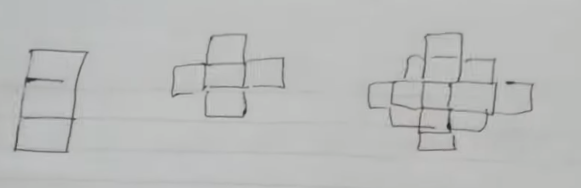
 
1. **Fit:** fit the height/width of the image.  
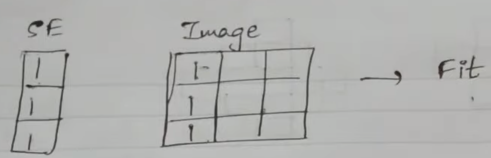

2. **Hit:** At least 1 of the elements matched (i.e. corresponding to at least element in SE)                                                       
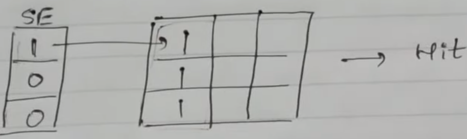

3. **Miss:** At least 1 of the elements matches (example below  miss-all)                                               
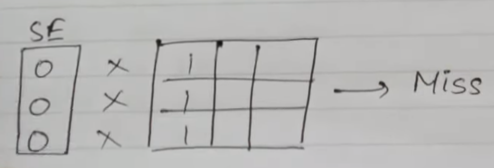
 
**Types of Structure Element:** Box & Disk type are among the most popular where 
+ Element values are 0, 1 and none (!)
+ Empty spots in the structuring elements are ignore
+ apart from this, SEs can have varying sizes.
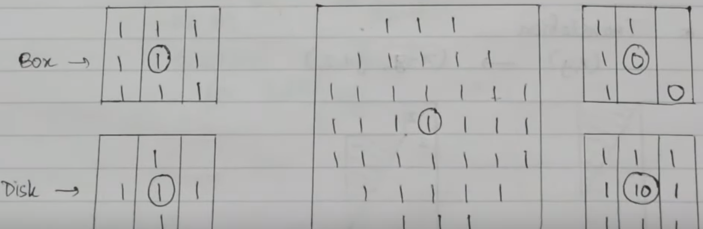

+ Different size of kernel example:                               
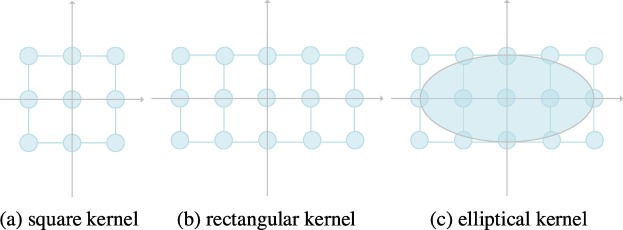

## Morphological Operation
### 1) Dilation and Erosion

-> **Dilation** *slices a kernel over the image. At each position, the pixel at the **anchor point** is replace by the maximum value found within the kernel's region where the Structure Element is nonzero. (note: pixel at anchor point is the pixel matched with SE anchor point).*


-> **Erosion** do **the same but choose the smallest value** then assigning it to the anchor point in the output. 

In [28]:
def kernel_region_of_interest(region, kernel):
    k_h, k_w = kernel.shape
    region_of_interest = []
    
    # iterate though kernel and retrieve HIT
    for row in range(k_h): 
        for col in range(k_w):
            if kernel[row, col] == 1:
                region_of_interest.append(region[row, col])
                
    return region_of_interest


region = np.array([
    [ 50,  80,  20 ],
    [100, 200, 150],
    [ 30,  90,  60]
])
kernel = np.array([[1, 0, 1],
                   [1, 1, 1],
                   [0, 1, 0]])

#? only retrieve value where kernel == 1
print(kernel_region_of_interest(region, kernel))


[np.int64(50), np.int64(20), np.int64(100), np.int64(200), np.int64(150), np.int64(90)]


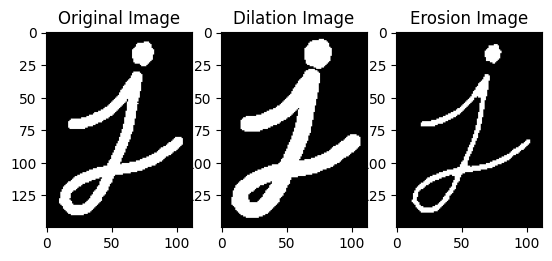

In [35]:
def morphological_operation(img, kernel, method): 
    #? 1. Get image and kernel shapes
    height, width = img.shape
    k_h, k_w = kernel.shape  # e.g., (3, 3)
    
    #? 2. Pad the image
    pad_h = k_h // 2  # e.g. 3 // 2 = 1 if k_h=3
    pad_w = k_w // 2
    new_height = height + 2*pad_h # add to 2 size horizontally    
    new_width = width + 2*pad_w  # add to 2 size vertically
    
    # Initialize padded image
    padded_img = np.zeros((new_height, new_width), dtype=img.dtype)
    # insert the original img inside the zeros "matrix with padding" 
    padded_img[pad_h:pad_h+height, pad_w:pad_w+width] = img
    
    #? 3. Create output array
    # zeros_like: Return an array of zeros with the same shape and type as a given array
    filtered_img = np.zeros_like(img, dtype=np.float32)
    
    #? 4. Convolution-like operation
    for i in range(height): # rows
        for j in range(width): # cols
            # local region in padded image        
            region = padded_img[i : i + k_h, j : j + k_w] # region_size == kernel_size
            #? considering only position where kernel == 1
            region_of_interest = kernel_region_of_interest(region, kernel)
            
            # assign to output
            if method == "dilation":
                filtered_img[i, j] = np.max(region_of_interest)
            elif method == "erosion":
                filtered_img[i, j] = np.min(region_of_interest)                
            else:
                raise ValueError("Unknown method...")
            
            
    # convert back to original datatype for display
    filtered_img = filtered_img.astype(img.dtype)
    return filtered_img


#? Cross-Shaped Kernel: Expands mainly in vertical and horizontal directions.
# kernel = np.array([[0, 1, 0],
#                    [1, 1, 1],
#                    [0, 1, 0]])
#? Same as above but expanded more in horizon -> soft, round expansion.
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
filter_grey_dilation = morphological_operation(greyscale_img, kernel, 'dilation')
filter_grey_erosion = morphological_operation(greyscale_img, kernel, 'erosion')

plt.subplot(1, 3, 1)
plt.imshow(greyscale_img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(filter_grey_dilation, cmap='gray')
plt.title('Dilation Image')

plt.subplot(1, 3, 3)
plt.imshow(filter_grey_erosion, cmap='gray')
plt.title('Erosion Image')

plt.show()

In [ ]:
hole_img = cv.imread('hole_text.png')
noise_img = cv.imread('noise_text.png')

hole_img = cv.cvtColor(hole_img, cv.COLOR_BGR2RGB)
noise_img = cv.cvtColor(noise_img, cv.COLOR_BGR2RGB)

greyscale_hole_img = cv.cvtColor(hole_img, cv.COLOR_BGR2GRAY)
greyscale_noise_img = cv.cvtColor(noise_img, cv.COLOR_BGR2GRAY)

#? Good kernel for closing and openning
openning_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
closing_kernel = np.ones((5,5), np.uint8)


#? Openning
erosion = morphological_operation(greyscale_noise_img, openning_kernel, 'erosion')
dilation = morphological_operation(erosion, openning_kernel, 'dilation')
openning = dilation

#? Closing
dilation = morphological_operation(greyscale_hole_img, closing_kernel, 'dilation')
erosion = morphological_operation(dilation, closing_kernel, 'erosion')
closing = erosion

<Figure size 640x480 with 0 Axes>

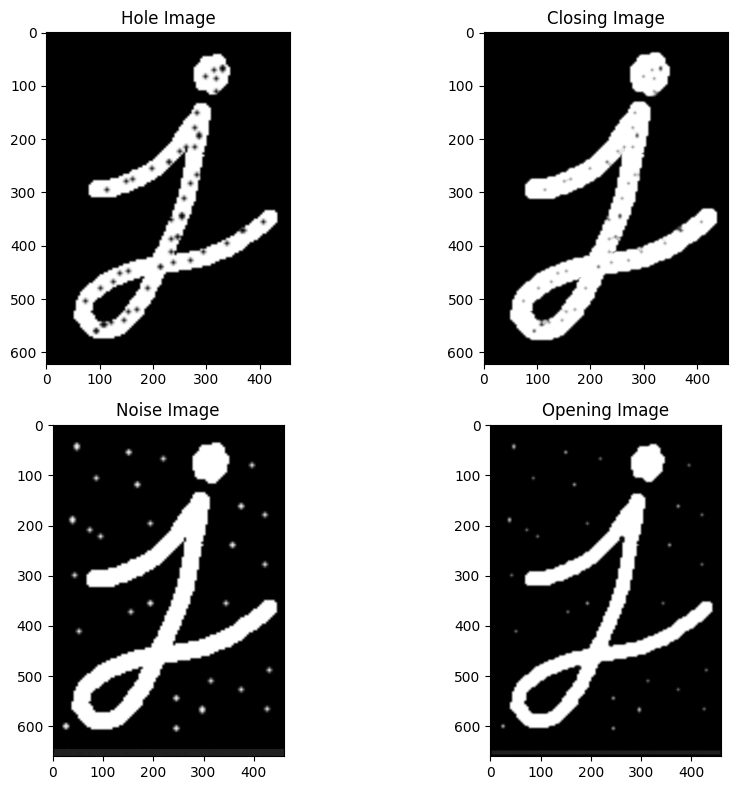

In [ ]:
plt.set_cmap('gray') # set cmap to all plot/subplot

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(hole_img)
plt.title('Hole Image')

plt.subplot(2, 2, 2)
plt.imshow(closing)
plt.title('Closing Image')

plt.subplot(2, 2, 3)
plt.imshow(noise_img)
plt.title('Noise Image')

plt.subplot(2, 2, 4)
plt.imshow(openning)
plt.title('Opening Image')

plt.tight_layout()
plt.show()